## The aim of creating this notebook is to check wether Train and Test sets are from same disstribution or not.

The entire point of doing this exercise is to make a better CV set that good indication about the Test set score as if the distributions are different creation of a simple Validation set from the Train set won't be a better indicator of how our model will perform on Public and Private Leaderboard.

__We will be using a technique known as Adversarial Validation for checking the same.__

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn import model_selection, preprocessing, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def change_dtype(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
    return df


def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def prepare_data(X, test=False):
    """
    Preparing final dataset with all features.
    """
    X.square_feet = np.log1p(X.square_feet)
    
    if not test:
        X.sort_values("timestamp", inplace=True)
        X.reset_index(drop=True, inplace=True)
    
    gc.collect()
    
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    
    X["hour"] = X.timestamp.dt.hour
    X["weekday"] = X.timestamp.dt.weekday
    X['year'] = X.timestamp.dt.year
    X.fillna(-1, inplace=True)
    year_min = X.timestamp.min().year
    X['age'] = X['year'] - year_min
    X["is_holiday"] = (X.timestamp.dt.date.astype("str").isin(holidays)).astype(int)
    X["combined_temp_1"] = (X['air_temperature'] + X['dew_temperature'])/2
    X["combined_temp_2"] = X['air_temperature'] - X['dew_temperature']
    X['air_temperature'] = np.absolute(X['air_temperature'])
    X['dew_temperature'] = np.absolute(X['dew_temperature'])
    
    
    drop_features = ["timestamp", "sea_level_pressure", "wind_direction", "wind_speed", "precip_depth_1_hr",
                     "cloud_coverage", "floor_count", 'year', 'year_built']

    X.drop(drop_features, axis=1, inplace=True)

    if test:
        row_ids = X.row_id
        X.drop("row_id", axis=1, inplace=True)
        return X, row_ids
    else:
        y = np.log1p(X.meter_reading)
        X.drop("meter_reading", axis=1, inplace=True)
        return X, y

In [3]:
df_build = pd.read_csv('building_metadata.csv')
df_weather_train = pd.read_csv('weather_train.csv')
df_train = pd.read_csv('train.csv')

In [4]:
df_train = change_dtype(df_train)
df_weather_train = change_dtype(df_weather_train)

In [5]:
df_train = df_train.merge(df_build, on='building_id', how='left')
df_train = df_train.merge(df_weather_train, on=['site_id', 'timestamp'], how='left')

del df_build, df_weather_train
gc.collect()

7

In [6]:
df_train = reduce_mem_usage(df_train)

Mem. usage decreased to 1041.10 Mb (60.3% reduction)


In [7]:
X, _ = prepare_data(df_train)

del df_train
gc.collect()

25

In [8]:
X.head()

,building_id,meter,site_id,primary_use,square_feet,air_temperature,dew_temperature,hour,weekday,age,is_holiday,combined_temp_1,combined_temp_2
0,0,0,0,Education,8.913685,25.000000,20.000000,0,4,0,1,22.50,5.00000
1,1104,1,13,Public services,12.204687,8.296875,12.203125,0,4,0,1,-10.25,3.90625
2,1104,0,13,Public services,12.204687,8.296875,12.203125,0,4,0,1,-10.25,3.90625
3,1103,0,13,Other,10.081801,8.296875,12.203125,0,4,0,1,-10.25,3.90625
4,1102,2,13,Office,11.375822,8.296875,12.203125,0,4,0,1,-10.25,3.90625


In [9]:
X['is_train'] = 1

In [10]:
X.head()

,building_id,meter,site_id,primary_use,square_feet,air_temperature,dew_temperature,hour,weekday,age,is_holiday,combined_temp_1,combined_temp_2,is_train
0,0,0,0,Education,8.913685,25.000000,20.000000,0,4,0,1,22.50,5.00000,1
1,1104,1,13,Public services,12.204687,8.296875,12.203125,0,4,0,1,-10.25,3.90625,1
2,1104,0,13,Public services,12.204687,8.296875,12.203125,0,4,0,1,-10.25,3.90625,1
3,1103,0,13,Other,10.081801,8.296875,12.203125,0,4,0,1,-10.25,3.90625,1
4,1102,2,13,Office,11.375822,8.296875,12.203125,0,4,0,1,-10.25,3.90625,1


In [11]:
df_build = pd.read_csv('building_metadata.csv')
df_weather_test = pd.read_csv('weather_test.csv')
df_test = pd.read_csv('test.csv')

df_test = change_dtype(df_test)
df_weather_test = change_dtype(df_weather_test)

df_test = df_test.merge(df_build, on='building_id', how='left')
df_test = df_test.merge(df_weather_test, on=['site_id', 'timestamp'], how='left')

del df_build, df_weather_test
gc.collect()

0

In [12]:
df_test = reduce_mem_usage(df_test)
gc.collect()

Mem. usage decreased to 2147.36 Mb (60.3% reduction)


22

In [13]:
df_test['is_train'] = 0
X_test, _ = prepare_data(df_test, test=True)
gc.collect()

44

In [14]:
X_test.head()

,building_id,meter,site_id,primary_use,square_feet,air_temperature,dew_temperature,is_train,hour,weekday,age,is_holiday,combined_temp_1,combined_temp_2
0,0,0,0,Education,8.913685,17.796875,11.703125,0,0,6,0,1,14.75,6.09375
1,1,0,0,Education,7.908755,17.796875,11.703125,0,0,6,0,1,14.75,6.09375
2,2,0,0,Education,8.589886,17.796875,11.703125,0,0,6,0,1,14.75,6.09375
3,3,0,0,Education,10.072639,17.796875,11.703125,0,0,6,0,1,14.75,6.09375
4,4,0,0,Education,11.666573,17.796875,11.703125,0,0,6,0,1,14.75,6.09375


In [15]:
drop_list = ['building_id', 'meter', 'site_id', 'primary_use']

X.drop(labels=drop_list, axis=1, inplace=True)
X_test.drop(labels=drop_list, axis=1,inplace=True)

gc.collect()

44

In [16]:
X.head()

,square_feet,air_temperature,dew_temperature,hour,weekday,age,is_holiday,combined_temp_1,combined_temp_2,is_train
0,8.913685,25.000000,20.000000,0,4,0,1,22.50,5.00000,1
1,12.204687,8.296875,12.203125,0,4,0,1,-10.25,3.90625,1
2,12.204687,8.296875,12.203125,0,4,0,1,-10.25,3.90625,1
3,10.081801,8.296875,12.203125,0,4,0,1,-10.25,3.90625,1
4,11.375822,8.296875,12.203125,0,4,0,1,-10.25,3.90625,1


In [17]:
X = X.sample(frac=0.1, random_state=3)
X_test = X_test.sample(frac=0.05, random_state=3)
gc.collect()

64

In [18]:
train_test = pd.concat([X, X_test], axis=0)

del X, X_test
gc.collect()

22

In [19]:
train, test = model_selection.train_test_split(train_test, test_size=0.33, random_state=42, shuffle=True)
del train_test
gc.collect()

32

In [20]:
columns = train.columns

In [21]:
train['is_train'].sample(10)

3936736     1
5595325     0
9803654     1
19285121    0
23188102    0
32045332    0
17610293    0
2721423     0
34258090    0
39371976    0
Name: is_train, dtype: int64

In [22]:
train_y = train['is_train'].values
test_y = test['is_train'].values
del train['is_train'], test['is_train']
gc.collect()

76

In [23]:
train = lgb.Dataset(train, label=train_y)
test = lgb.Dataset(test, label=test_y)
gc.collect()

22

In [24]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 2,
         'learning_rate': 0.2,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 44,
         "metric": 'auc',
         "verbosity": -1}

In [25]:
num_round = 50
clf = lgb.train(param, train, num_round, valid_sets = [train, test], verbose_eval=50, early_stopping_rounds = 50)

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.777241	valid_1's auc: 0.776771
Did not meet early stopping. Best iteration is:
[48]	training's auc: 0.777591	valid_1's auc: 0.777113


__It can been seen that AUC is significantly high, which indicates that model is able classify the two sets which means the distribution os test and train set
is different, hence indication creating validation set by some simple technique will not be a good indicator of model's performance on the test set.__

But <a href="https://www.kaggle.com/tunguz/adversarial-ashrae"> this notebook</a> suggests otherwise, it means by creating new features we are changing the distribution of the train and test set, hence a model trained on this train set will not generalize well for the test set.

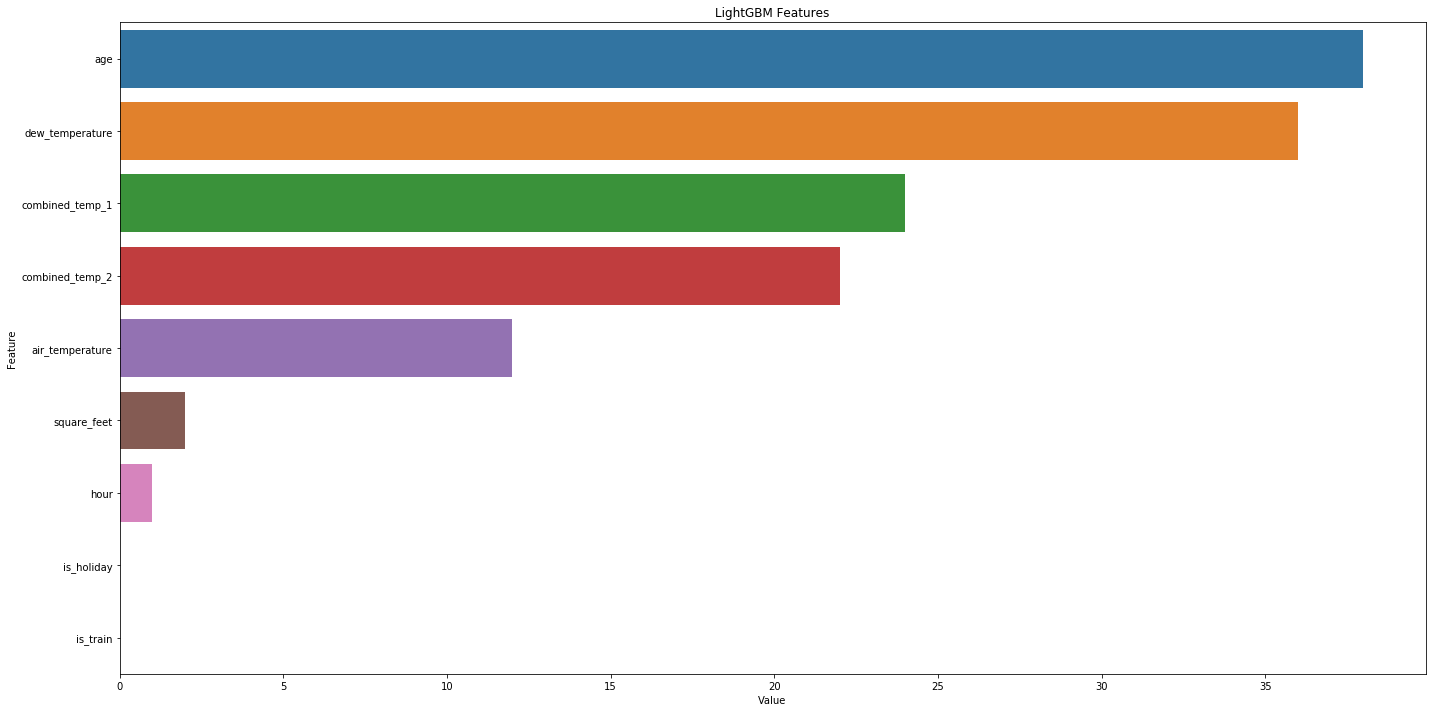

<Figure size 432x288 with 0 Axes>

In [26]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')